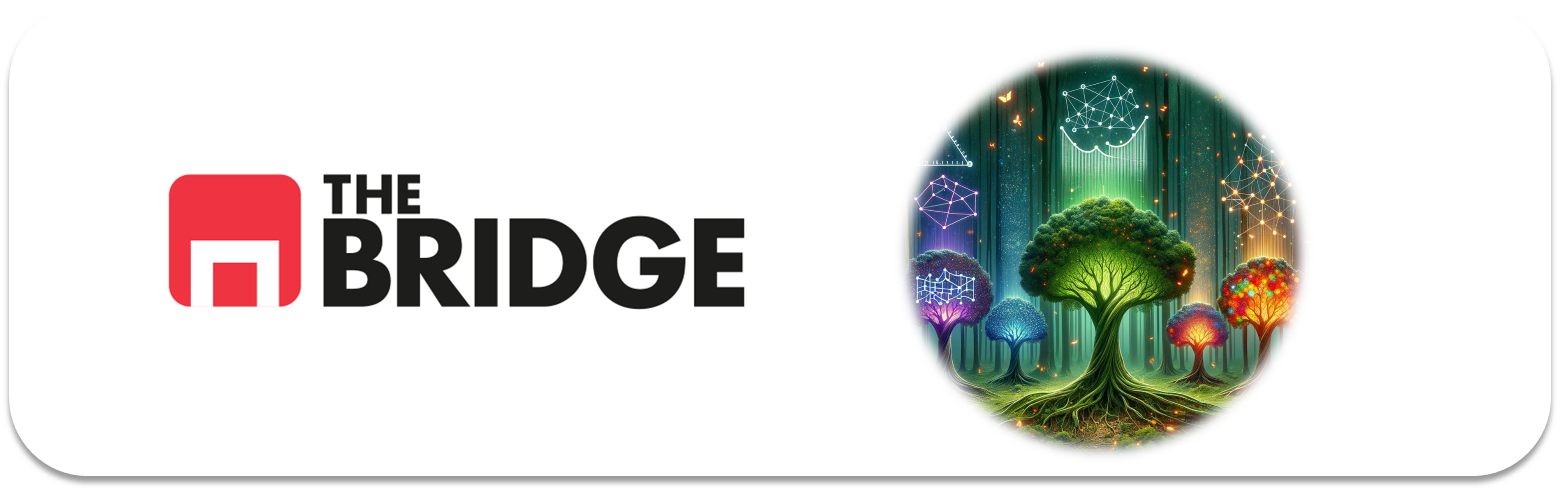

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

import datascience as ds
import vizdatatools as viz

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

# 1. Cargar los datos

In [2]:
df_bank = pd.read_csv('./data/bank-full.csv', sep=';')
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


# 2. Hacer breve inspección de los datos

In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
df_bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
ds.get_cardinality(df_bank, threshold_categorical=13)

pandas.DataFrame shape:  (45211, 17)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
age,77,0.170313,0,0.0,int64,Numeric - Discrete
job,12,0.026542,0,0.0,object,Categoric
marital,3,0.006636,0,0.0,object,Categoric
education,4,0.008847,0,0.0,object,Categoric
default,2,0.004424,0,0.0,object,Binary
balance,7168,15.854549,0,0.0,int64,Numeric - Discrete
housing,2,0.004424,0,0.0,object,Binary
loan,2,0.004424,0,0.0,object,Binary
contact,3,0.006636,0,0.0,object,Categoric
day,31,0.068567,0,0.0,int64,Numeric - Discrete


# 3. Analizar distribución del target.

El *target* es "y", "yes" es el caso de exito que buscamos. Pero vamos a encontrar que está muy desbalanceado. 

Por el momento voy a mantener el resto de feturures pues no tengo conocimiento suficiente para descartar ninguna.

Es un problema de clasificación binaria y por tanto en un árbol de decisión podré usar varaibles numéricas y categóricas.

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


C:\Users\Lander\AppData\Local\Temp\ipykernel_18120\3556922640.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_bank['y'] = df_bank['y'].replace({'no': 0, 'yes': 1})


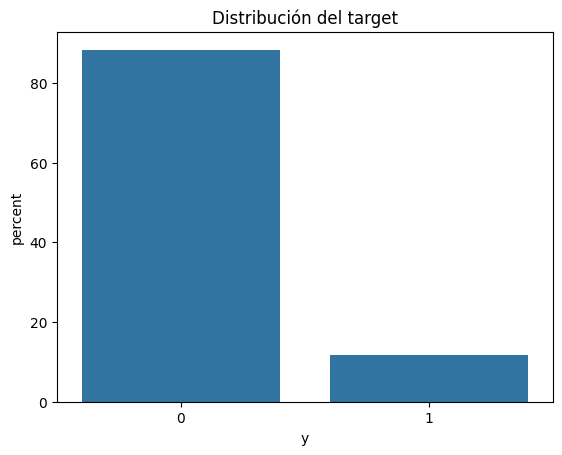

In [6]:
# Analizar la distribución del target
target = 'y'

# Modifico "y" a numérica para poder hacer test de correlación
df_bank['y'] = df_bank['y'].replace({'no': 0, 'yes': 1})

print(df_bank[target].value_counts(True))

sns.countplot(df_bank, x='y', stat='percent')
plt.title('Distribución del target')
plt.show()

# 4. Separar train y test

In [7]:
# Separar los datos en entrenamiento y prueba
train_set, test_set = train_test_split(df_bank, test_size=0.2, random_state=42, stratify=df_bank['y'])

print(train_set['y'].value_counts(True))
print(test_set['y'].value_counts(True))

# Separar X e y
X_train = train_set.drop(target, axis=1)
y_train = train_set[target]
X_test = test_set.drop(target, axis=1)
y_test = test_set[target]

y
0    0.883018
1    0.116982
Name: proportion, dtype: float64
y
0    0.883003
1    0.116997
Name: proportion, dtype: float64


# 5. Mini EDA y procesamiento

Features categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


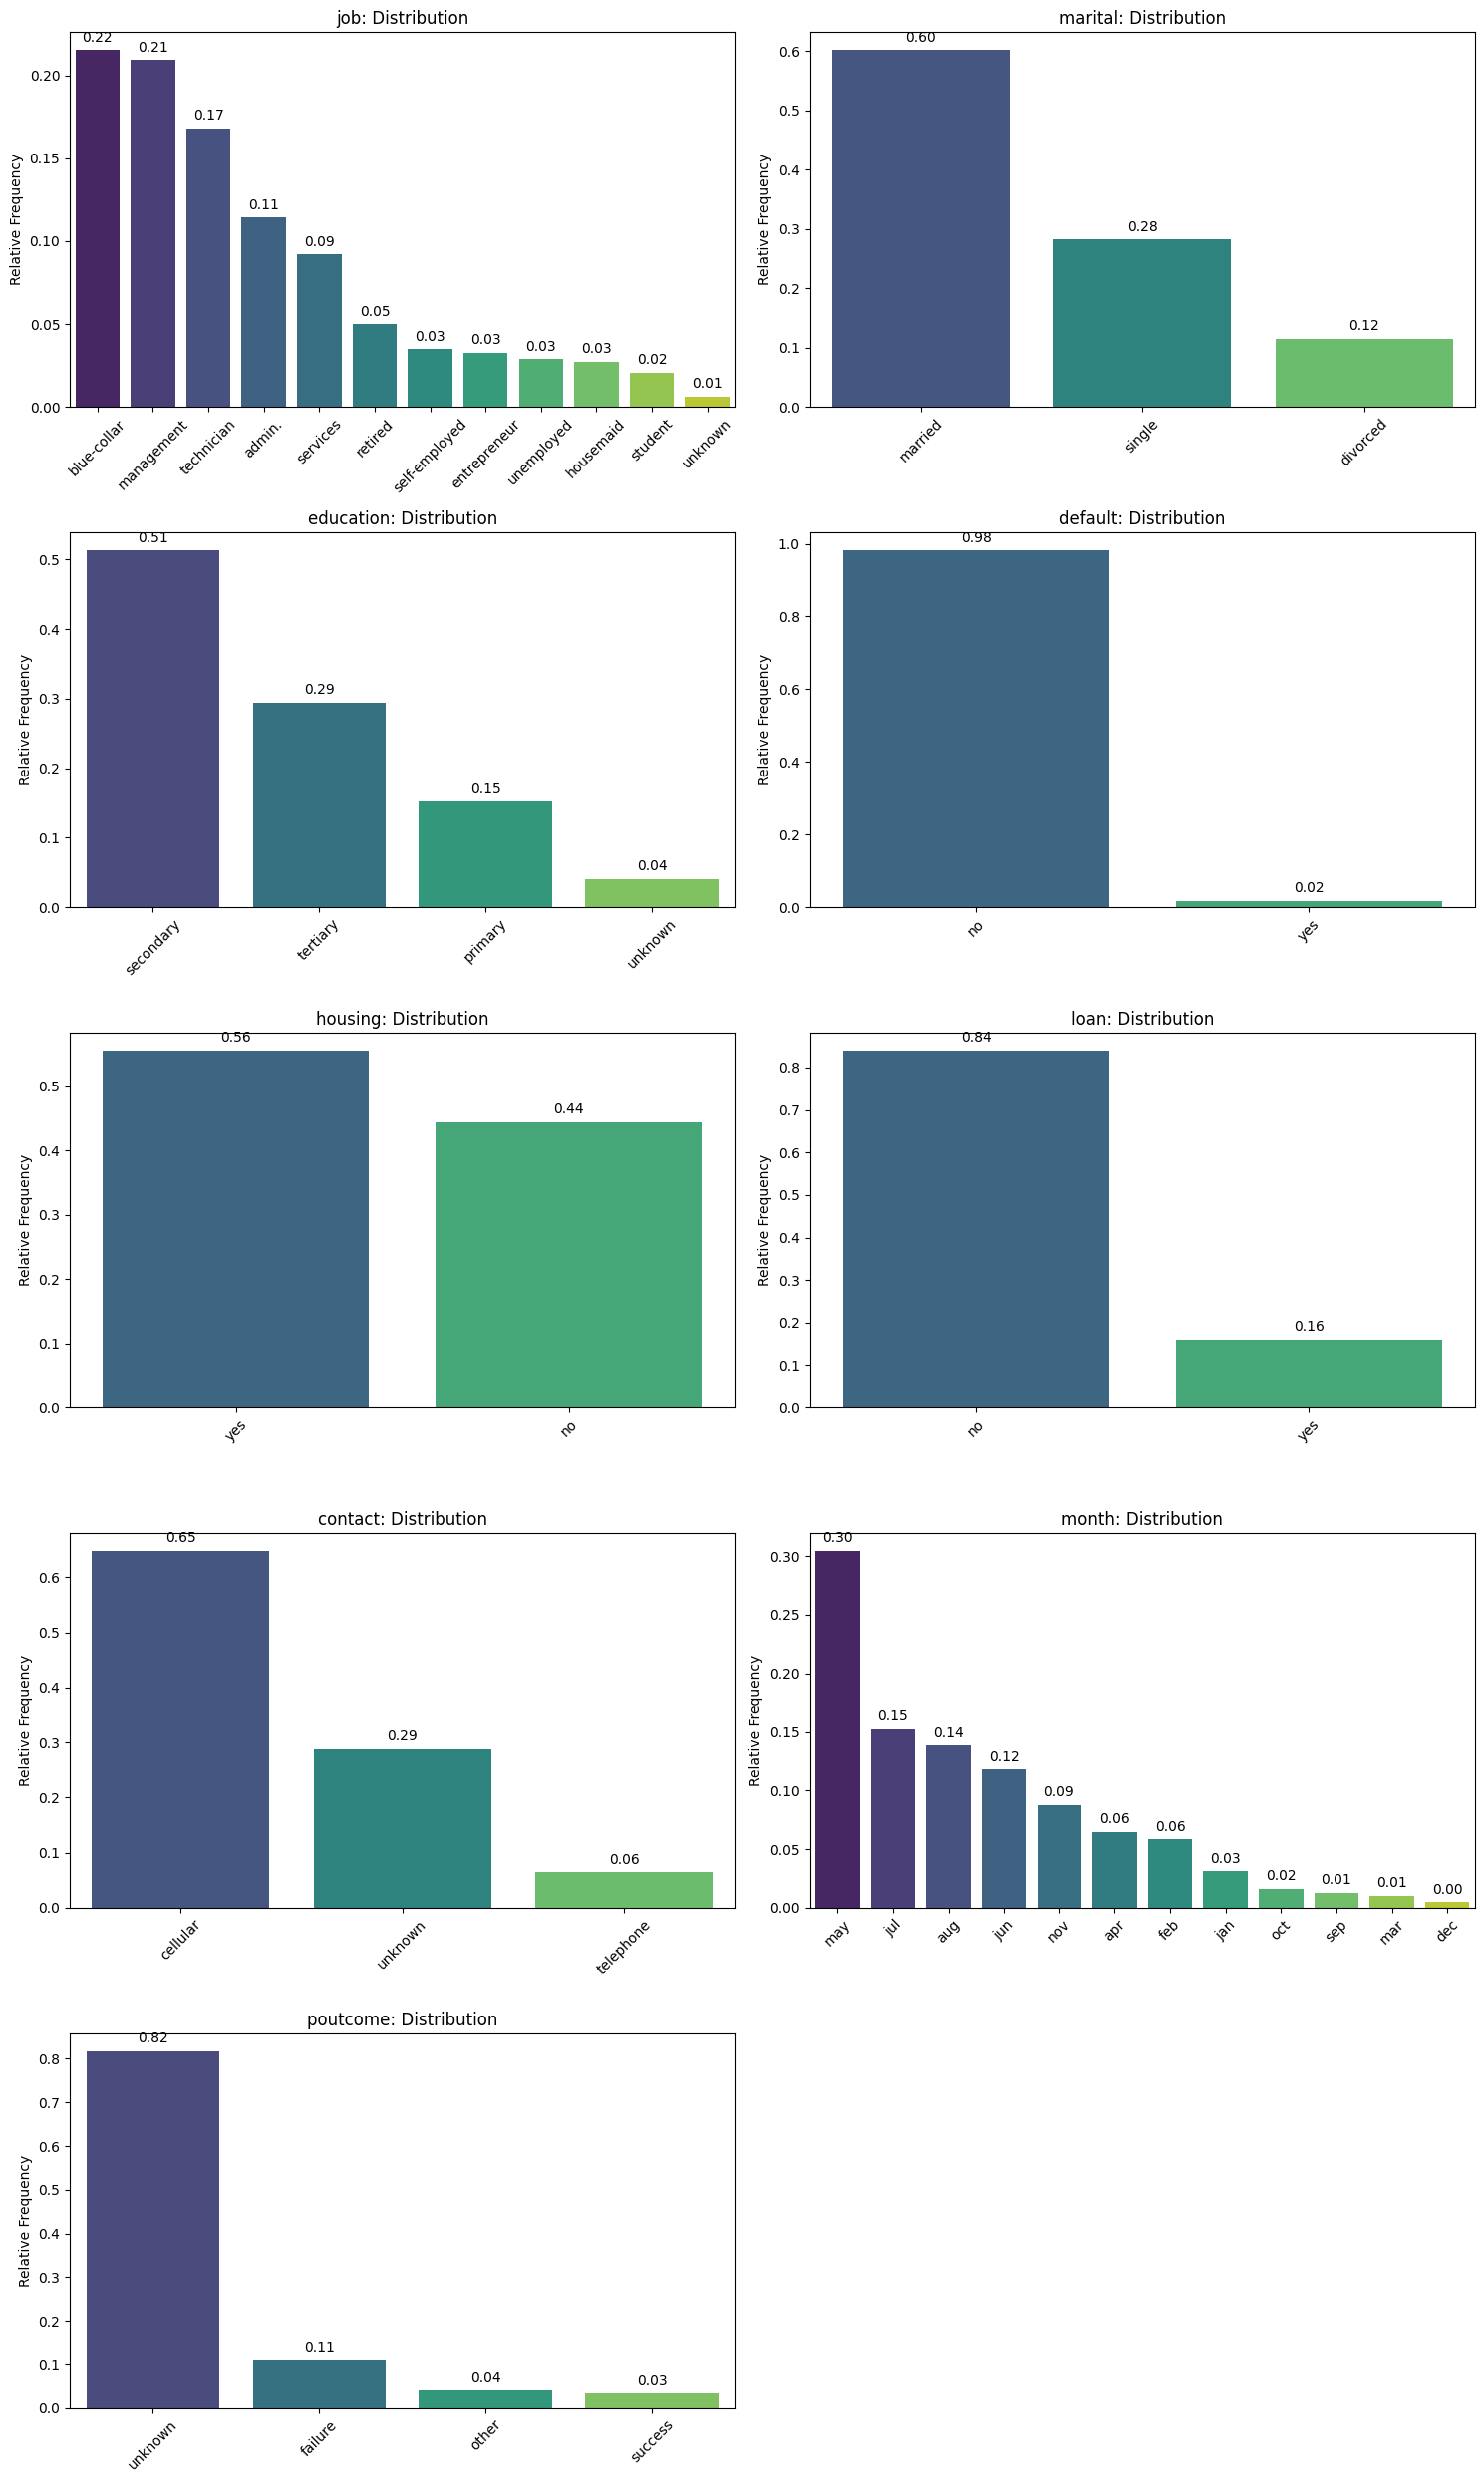

Features numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


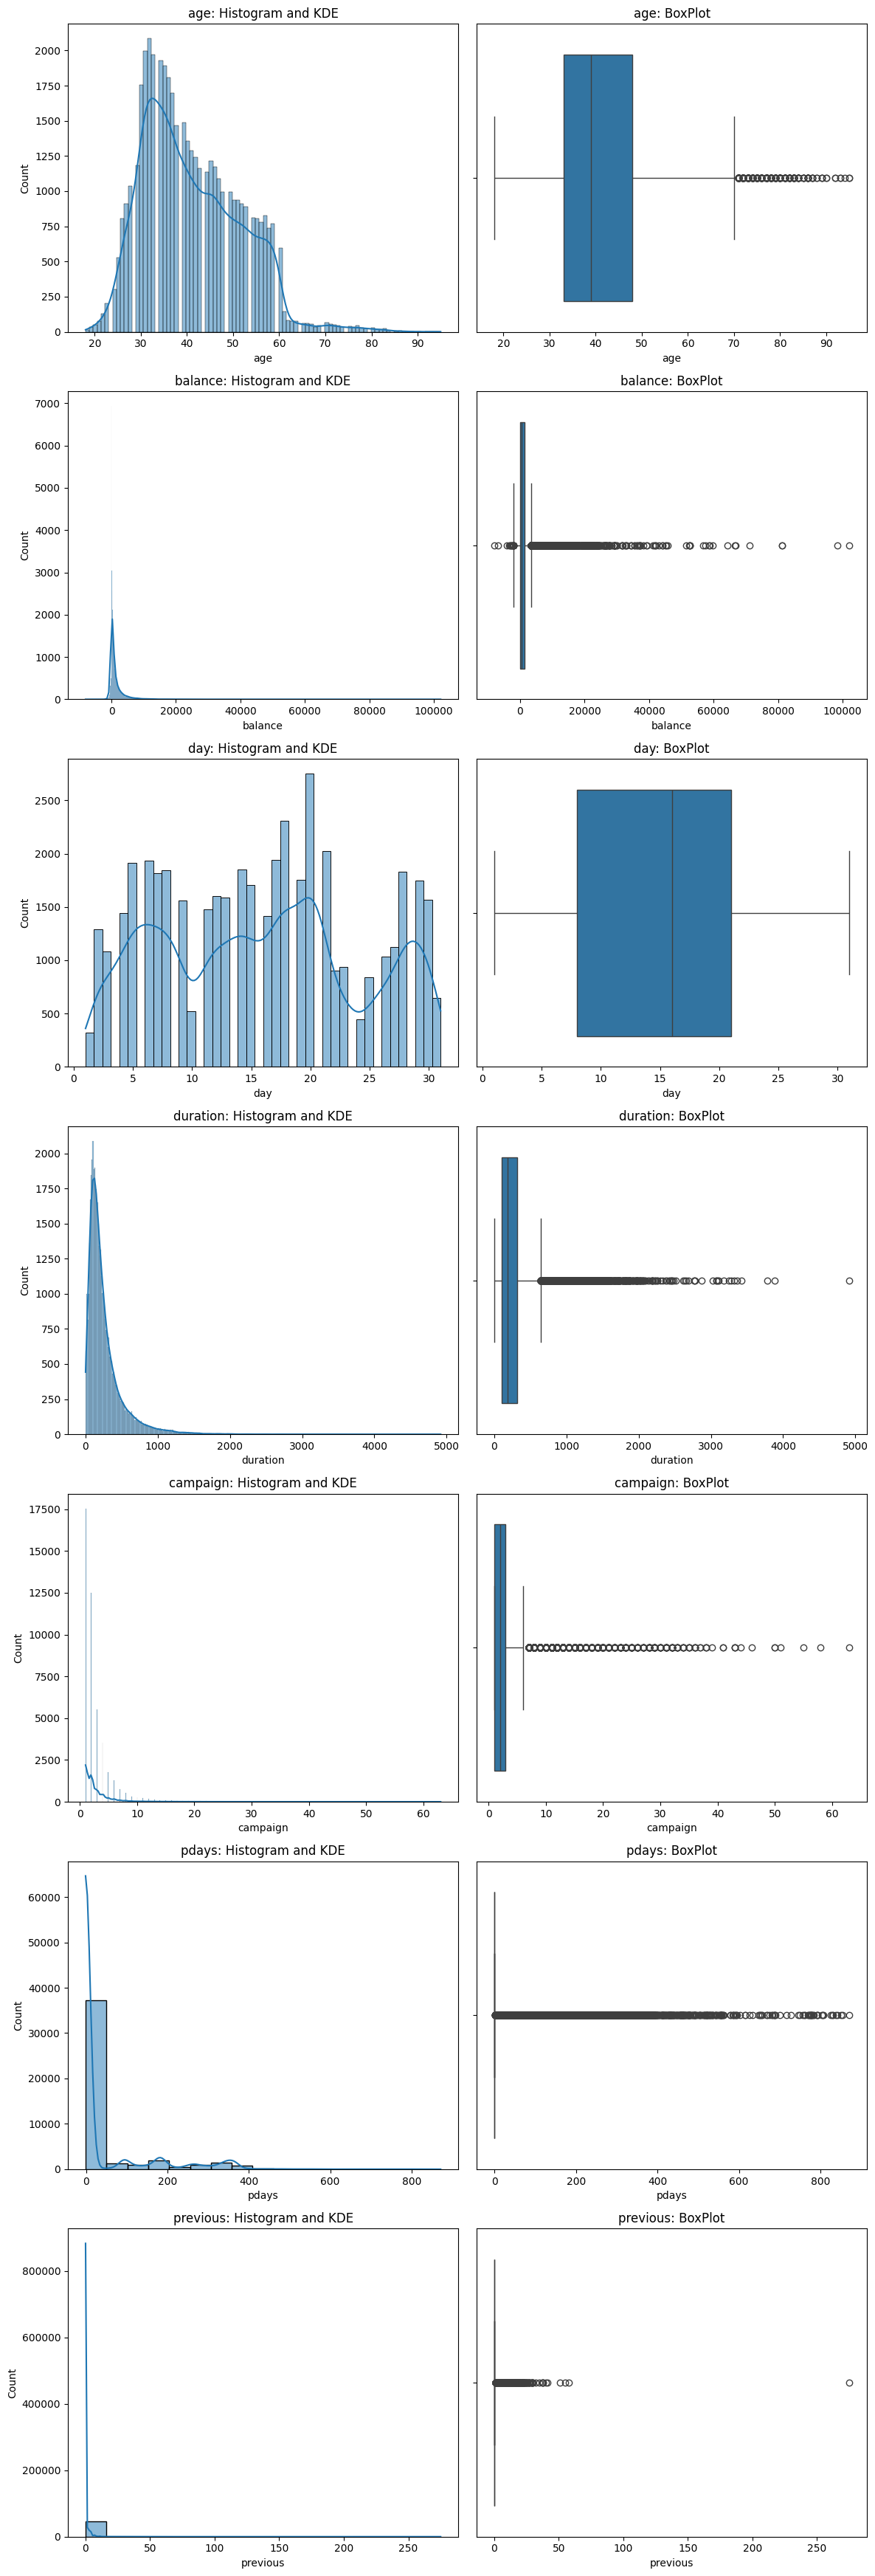

In [8]:
# Selección de features
cat_features = X_train.select_dtypes(include=['object']).columns
num_features = X_train.select_dtypes(include=['number']).columns

# Análisis univariante
print("Features categóricas:", cat_features.to_list())
viz.plot_multiple_categorical_distributions(df_bank,
                                            cat_features,
                                            relative=True
                                            )

print("Features numéricas:", num_features.to_list())
viz.plot_multiple_histograms_KDEs_boxplots(df_bank,
                                           num_features
                                           )

"balance" y "duration" tiene una variabilidad muy grande.

Afortunadamente no hay valores missing.

<Axes: >

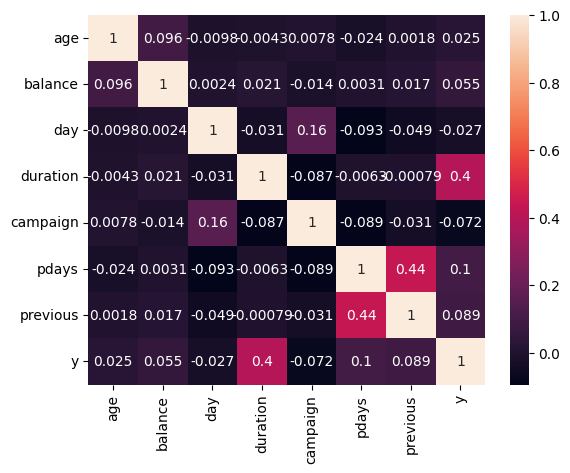

In [9]:
# Correlación lineal. Me fijo en "y"
sns.heatmap(train_set.corr(numeric_only=True), annot=True)

Mantengo todas las variables numéricas.

# 6. Tratamiento de features categóricas

Por definición, los árboles de decisión permiten trabajar con categorías, pero los modelos de sklearn necesitan variables numéricas para trabajar correctamente, así realizo un one-hot encoding.


In [10]:
# One-Hot Encoder para las variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)  # Passthrough para las características numéricas
    ],
    remainder='passthrough'
)

# Aplicar el preprocesador al conjunto de entrenamiento y prueba
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Obtener los nombres de las columnas categóricas después del One-Hot Encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
all_feature_names = cat_feature_names.tolist() + num_features.to_list()

# Crear DataFrames con las características codificadas
X_train = pd.DataFrame(X_train, columns=all_feature_names)
X_test = pd.DataFrame(X_test, columns=all_feature_names)

print("Columnas después de One-Hot Encoding (sklearn):")
print(X_train.columns)
print("Forma de X_train_encoded después de One-Hot Encoding (sklearn):")
display(pd.DataFrame(X_train))

Columnas después de One-Hot Encoding (sklearn):
Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age', 'balance', 'day', 'duration', 'campaign',
       'pdays', 'previous'],
      dtype='object')
Forma de X_train_encoded después de One-Hot

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,36.0,861.0,29.0,140.0,2.0,-1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,24.0,4126.0,5.0,907.0,4.0,185.0,7.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,44.0,244.0,12.0,1735.0,4.0,-1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,48.0,0.0,31.0,35.0,11.0,-1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,38.0,257.0,26.0,57.0,10.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36163,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,50.0,917.0,30.0,58.0,2.0,-1.0,0.0
36164,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,36.0,22.0,22.0,77.0,5.0,-1.0,0.0
36165,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,45.0,79.0,25.0,98.0,1.0,-1.0,0.0
36166,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,27.0,2559.0,6.0,227.0,1.0,-1.0,0.0


# 7. Tratamiento de variables numéricas

Los árboles de decisión son insensibles a la escala de los datos porque dividen los datos basándose en umbrales en las características, por lo que las magnitudes o rangos de las variables no afectan al rendimiento del modelo. 

En contraste con modelos como la regresión logística, SVM o redes neuronales, donde la magnitud de las características influye en la convergencia o en los pesos asignados a cada característica, los árboles de decisión no requieren este tipo de preprocesamiento.

Por tanto, y como quiero comparar con un modelo de regresión logística, voy a tener que hacer el procesamiento de las numéricas.

No estoy seguro de esto, pero ya que he hecho un one-hot encoding sobre las variables numéricas, voy a hacer un min-max scaling (normalización) sobre las numéricas, para que tengan valores entre 0 y 1. (Aunque normalmente hacemos escalado para los modelos de regresión logística)

La normalización es útil cuando se sabe que los datos siguen una distribución no gaussiana o cuando los modelos son sensibles a las magnitudes de los valores. Es ideal para modelos como K-Nearest Neighbors (KNN) o Redes Neuronales, donde las distancias entre los datos son importantes y donde diferentes escalas pueden afectar los resultados.

In [11]:
num_features

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [12]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

X_train[num_features] = pd.DataFrame(min_max_scaler.fit_transform(X_train[num_features]), columns=num_features)
X_test[num_features] = pd.DataFrame(min_max_scaler.transform(X_test[num_features]), columns=num_features)

display(X_train.describe())
display(X_test.describe())

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
count,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,...,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000,36168.000000
mean,0.114493,0.216490,0.032791,0.028008,0.207670,0.050100,0.034367,0.092568,0.020958,0.167773,...,0.041058,0.033317,0.818099,0.297312,0.085200,0.493932,0.052563,0.028451,0.047199,0.002115
std,0.318414,0.411858,0.178093,0.164998,0.405645,0.218153,0.182174,0.289830,0.143245,0.373669,...,0.198428,0.179465,0.385768,0.138014,0.027859,0.277733,0.052693,0.050067,0.114865,0.008759
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.194805,0.073475,0.233333,0.020943,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.272727,0.076898,0.500000,0.036600,0.016129,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.389610,0.085788,0.666667,0.064660,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
count,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,...,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000,9043.000000
mean,0.113900,0.210328,0.033285,0.025102,0.215305,0.049983,0.037156,0.089130,0.019905,0.169081,...,0.039257,0.033838,0.814995,0.300117,0.085054,0.492009,0.052214,0.028443,0.047431,0.002090
std,0.317708,0.407564,0.179391,0.156444,0.411056,0.217923,0.189154,0.284947,0.139681,0.374844,...,0.194216,0.180823,0.388323,0.137458,0.026763,0.276155,0.051032,0.049573,0.114677,0.006627
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.045040,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.194805,0.073403,0.233333,0.020943,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.272727,0.076771,0.500000,0.036397,0.016129,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.402597,0.085577,0.666667,0.065474,0.032258,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.974026,0.966317,1.000000,0.667751,0.870968,0.962156,0.134545


Comprobado que en el test_set los valores también están entre 0 y 1.

# 8. Árbol de decisión *baseline*


In [13]:
# Entrenamiento de un modelo de árbol de decisión (baseline)
tree_baseline_clf = DecisionTreeClassifier(random_state=42)
tree_baseline_clf.fit(X_train, y_train)

# Predicción sobre train
pred_train_tree_baseline = tree_baseline_clf.predict(X_train)

# Evaluación inicial sobre train
print("Accuracy del Árbol de Decisión:", accuracy_score(y_train, pred_train_tree_baseline))
print("\nMatriz confusión\n", confusion_matrix(y_train, pred_train_tree_baseline))
print("\nClassification Report\n", classification_report(y_train, pred_train_tree_baseline))


Accuracy del Árbol de Decisión: 1.0

Matriz confusión
 [[31937     0]
 [    0  4231]]

Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     31937
           1       1.00      1.00      1.00      4231

    accuracy                           1.00     36168
   macro avg       1.00      1.00      1.00     36168
weighted avg       1.00      1.00      1.00     36168



Hacer la evaluación sobre train en un árbol sin hiperparámetros no tiene sentido porque ha hecho un overfit brutal.

# 9. Árbol de decisión con optimización de hiperparámetros mediante *Grid Search*

In [14]:
# Definir el grid de hiperparámetros
tree_grid_param = {
    'max_depth': [3, 5, 10, 20, None],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],    # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],      # Mínimo número de muestras en un nodo hoja
    'criterion': ['gini', 'entropy'],   # Función de medición de la calidad de una división
}

# Inicializar GridSearchCV
tree_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           tree_grid_param, 
                           cv=5, 
                           scoring='accuracy',
                           n_jobs=-1)

# Ajuste
tree_grid_search.fit(X_train, y_train)

# Mejores hiperparámetros
print("Mejores hiperparámetros:", tree_grid_search.best_params_)
print("Mejor accuracy:", tree_grid_search.best_score_)
print("Mejor modelo:", tree_grid_search.best_estimator_)

# predicción sobre train
pred_train_tree_opt = tree_grid_search.best_estimator_.predict(X_train)

# Evaluación inicial sobre train
print("Accuracy del Árbol de Decisión:", accuracy_score(y_train, pred_train_tree_opt))
print("\nMatriz confusión\n", confusion_matrix(y_train, pred_train_tree_opt))
print("\nClassification Report\n", classification_report(y_train, pred_train_tree_opt))



Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor accuracy: 0.9023170191028044
Mejor modelo: DecisionTreeClassifier(max_depth=5, random_state=42)
Accuracy del Árbol de Decisión: 0.904777704047777

Matriz confusión
 [[31340   597]
 [ 2847  1384]]

Classification Report
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     31937
           1       0.70      0.33      0.45      4231

    accuracy                           0.90     36168
   macro avg       0.81      0.65      0.70     36168
weighted avg       0.89      0.90      0.89     36168



# 10. Regresión logística

In [15]:
# Entrenar un modelo de regresión logística
logreg_clf = LogisticRegression(max_iter=1000)
logreg_clf.fit(X_train, y_train)

# Predicciones
pred_train_logreg = logreg_clf.predict(X_train)

# Evaluación de la regresión logística
print("Accuracy de la Regresión Logística:", accuracy_score(y_train, pred_train_logreg))
print("\nMatriz confusión\n", confusion_matrix(y_train, pred_train_logreg))
print("\nClassification Report\n", classification_report(y_train, pred_train_logreg))


Accuracy de la Regresión Logística: 0.9020128290201282

Matriz confusión
 [[31243   694]
 [ 2850  1381]]

Classification Report
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     31937
           1       0.67      0.33      0.44      4231

    accuracy                           0.90     36168
   macro avg       0.79      0.65      0.69     36168
weighted avg       0.89      0.90      0.89     36168



# 11. Evaluación contra test de los tres modelos

In [17]:
# Predicciones sobre test
pred_test_tree_baseline = tree_baseline_clf.predict(X_test)
pred_test_tree_opt = tree_grid_search.best_estimator_.predict(X_test)
pred_test_logreg = logreg_clf.predict(X_test)

# Evaluación
print("Classification Report Tree Baseline\n", classification_report(y_test, pred_test_tree_baseline))
print("Classification Report Tree con hiperparámetros optimizados\n", classification_report(y_test, pred_test_tree_opt))
print("Classification Report Regresión Logística\n", classification_report(y_test, pred_test_logreg))

Classification Report Tree Baseline
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7985
           1       0.46      0.47      0.47      1058

    accuracy                           0.87      9043
   macro avg       0.70      0.70      0.70      9043
weighted avg       0.88      0.87      0.87      9043

Classification Report Tree con hiperparámetros optimizados
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      7985
           1       0.65      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043

Classification Report Regresión Logística
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.65      0.32      0.43      1058

    accuracy                           0.9

La optimización mejora la precisión y recall del modelo baseline, pero no tanto en la clase minoritaria (1), que es la que queremos predecir, donde sigue habiendo un claro desbalance.

El rendimiento de la regresión logística es bastante similar al modelo optimizado, con mejor balance entre clases, aunque ambos sufren en cuanto al recall de la clase minoritaria.